# AMPLPY: Pattern Generation

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ampl/amplpy/blob/master/notebooks/pattern_generation.ipynb)

Documentation: http://amplpy.readthedocs.io

GitHub Repository: https://github.com/ampl/amplpy

PyPI Repository: https://pypi.python.org/pypi/amplpy

Jupyter Notebooks: https://github.com/ampl/amplpy/tree/master/notebooks

### Setup

In [1]:
!pip install -q amplpy matplotlib numpy

### Google Colab integration

In [2]:
%%bash
test ! -z $COLAB_GPU || exit 0  # Run only if running on Google Colab
test ! -f ampl.installed || exit 0  # Run only once
rm -rf ampl.linux-intel64
# You can install a demo bundle with all solvers:
#   curl -O https://portal.ampl.com/dl/amplce/ampl.linux64.tgz && tar xzf ampl.linux64.tgz
# Or pick individual modules (recommended in order to reduce disk usage):
curl -O https://portal.ampl.com/dl/modules/ampl-module.linux64.tgz && tar xzf ampl-module.linux64.tgz
curl -O https://portal.ampl.com/dl/modules/gurobi-module.linux64.tgz && tar xzf gurobi-module.linux64.tgz
cp ampl.linux-intel64/ampl.lic ampl.linux-intel64/ampl.lic.demo
touch ampl.installed

In [3]:
%%bash
# If you have an AMPL Cloud License or an AMPL CE license, you can use it on Google Colab
# Note: Your license UUID should never be shared. Please make sure you delete the license UUID
# and rerun this cell before sharing the notebook with anyone
LICENSE_UUID=
test ! -z $COLAB_GPU || exit 0  # Run only if running on Google Colab
cd ampl.linux-intel64 && pwd
test -z $LICENSE_UUID && cp ampl.lic.demo ampl.lic  # Restore demo license in case LICENSE_UUID is empty
test ! -z $LICENSE_UUID && curl -O https://portal.ampl.com/download/license/$LICENSE_UUID/ampl.lic
./ampl -vvq

In [4]:
import os
if 'COLAB_GPU' in os.environ:
    os.environ['PATH'] += os.pathsep + '/content/ampl.linux-intel64'

### Import and instantiate

In [5]:
from amplpy import AMPL, register_magics
from math import floor
ampl = AMPL()
# Store %%ampl cells in the list _ampl_cells
# Evaluate %%ampl_eval cells with ampl.eval()
register_magics(store_name='_ampl_cells', ampl_object=ampl)

### Basic pattern-cutting model

In [6]:
%%ampl_eval
param nPatterns integer > 0;
set PATTERNS = 1..nPatterns; # patterns
set WIDTHS; # finished widths
param order {WIDTHS} >= 0; # rolls of width j ordered
param overrun; # permitted overrun on any width
param rolls {WIDTHS,PATTERNS} >= 0 default 0; # rolls of width i in pattern j

var Cut {PATTERNS} integer >= 0; # raw rolls to cut in each pattern

minimize TotalRawRolls: sum {p in PATTERNS} Cut[p];

subject to FinishedRollLimits {w in WIDTHS}:
  order[w] <= sum {p in PATTERNS} rolls[w,p] * Cut[p] <= order[w] + overrun;

### Plotting routine

In [7]:
def cuttingPlot(roll_width, widths, solution):
    import numpy as np
    import matplotlib.pyplot as plt
    ind = np.arange(len(solution))
    acc = [0]*len(solution)
    for p, (patt, rep) in enumerate(solution):
        for i in range(len(widths)):
            for j in range(patt[i]):
                vec = [0]*len(solution)
                vec[p] = widths[i]
                plt.bar(ind, vec, width=0.35, bottom=acc)
                acc[p] += widths[i]
    plt.title('Solution')
    plt.xticks(ind, tuple("x {:}".format(rep) for patt, rep in solution))
    plt.yticks(np.arange(0, roll_width, 10))
    plt.show()

### Set data

In [8]:
roll_width = 64.5
overrun = 6
orders = {
    6.77: 10,
    7.56: 40,
    17.46: 33,
    18.76: 10
}
widths = list(sorted(orders.keys(), reverse=True))

### Send data to AMPL (Java/C++ style)

In [9]:
# Send scalar values
ampl.getParameter('overrun').set(overrun)
ampl.getParameter('nPatterns').set(len(widths))
# Send order vector
ampl.getSet('WIDTHS').setValues(widths)
ampl.getParameter('order').setValues(orders)
# Generate and send initial pattern matrix
ampl.getParameter('rolls').setValues({
    (widths[i], 1+i): int(floor(roll_width/widths[i]))
    for i in range(len(widths))
})

### Send data to AMPL (alternative style)

In [10]:
# Send scalar values
ampl.param['overrun'] = overrun
ampl.param['nPatterns'] = len(widths)
# Send order vector
ampl.set['WIDTHS'] = widths
ampl.param['order'] = orders
# Generate and send initial pattern matrix
ampl.param['rolls'] = {
    (widths[i], 1+i): int(floor(roll_width/widths[i]))
    for i in range(len(widths))
}

### Set up for generation loop

In [11]:
# Set solve options
ampl.option['solver'] = 'gurobi'
ampl.option['relax_integrality'] =  1

# Create a param for sending AMPL new patterns
ampl.eval('param newpat {WIDTHS} integer >= 0;')
new_pattern = ampl.param['newpat']

### Define the knapsack subproblem

In [12]:
# Define the knapsack subproblem
subprob = AMPL()
subprob.option['solver'] = 'gurobi'
subprob.eval('''
    set WIDTHS;
    param W >= 0;
    param v{WIDTHS} >= 0;
    var x{WIDTHS} integer >= 0;
    maximize profit: sum {w in WIDTHS} v[w]*x[w];
    subject to capacity: sum {w in WIDTHS} w*x[w] <= W;
''')
subprob.set['WIDTHS'] = widths
subprob.param['W'] = roll_width
values = subprob.param['v']
kpsolution = subprob.var['x']
profit = subprob.obj['profit']

### Loop

In [13]:
limits = ampl.getConstraint('FinishedRollLimits')
while True:
    print('Master problem:')
    ampl.solve()
    print()

    # Retrieve duals & look for new pattern
    # Solve knapsack problem for potential new pattern
    values.setValues(limits.getValues())
    print('Subproblem:')
    subprob.solve()
    print()
    if profit.value() <= 1.000001:
        break

    # Send new pattern to AMPL
    new_pattern.setValues(kpsolution.getValues())
    ampl.eval('let nPatterns := nPatterns + 1;')
    ampl.eval('let {w in WIDTHS} rolls[w, nPatterns] := newpat[w];')

Master problem:
Gurobi 9.5.0: optimal solution; objective 20.44444444

Subproblem:
Gurobi 9.5.0: optimal solution; objective 1.152777778
1 simplex iterations
1 branch-and-cut nodes

Master problem:
Gurobi 9.5.0: optimal solution; objective 18.77777778
1 simplex iterations

Subproblem:
Gurobi 9.5.0: optimal solution; objective 1.111111111

Master problem:
Gurobi 9.5.0: optimal solution; objective 18.375
3 simplex iterations

Subproblem:
Gurobi 9.5.0: optimal solution; objective 1.125
1 simplex iterations
1 branch-and-cut nodes

Master problem:
Gurobi 9.5.0: optimal solution; objective 17.95833333
5 simplex iterations

Subproblem:
Gurobi 9.5.0: optimal solution; objective 1.041666667
2 simplex iterations
1 branch-and-cut nodes

Master problem:
Gurobi 9.5.0: optimal solution; objective 17.94117647
5 simplex iterations

Subproblem:
Gurobi 9.5.0: optimal solution; objective 1
1 simplex iterations
1 branch-and-cut nodes



### Compute and display integer solution

Gurobi 9.5.0: optimal solution; objective 19
5 simplex iterations
1 branch-and-cut nodes
[0.0, 0.0, 0.0, 0.0, 10.0, 4.0, 4.0, 1.0]


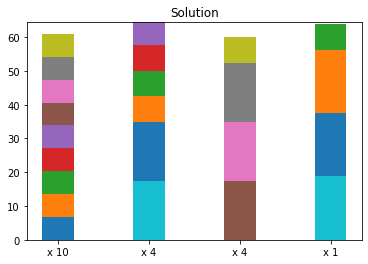

In [14]:
# Compute and display integer solution
ampl.option['relax_integrality'] = 0
ampl.solve()

# Retrieve solution
cutting_plan = ampl.var['Cut'].getValues()
cutvec = list(cutting_plan.getColumn('Cut.val'))
print(cutvec)

# Display solution
rolls = ampl.param['rolls']
npatterns = int(ampl.param['nPatterns'].value())
solution = [
    ([int(rolls[widths[i], p]) for i in range(len(widths))], int(cutvec[p]))
    for p in range(npatterns)
    if cutvec[p] > 0
]
cuttingPlot(roll_width, widths, solution)